# Dependency

In [42]:
import h5py
import os
import pickle
from tqdm import tqdm
from time import gmtime, strftime
import numpy as np
import math
from sklearn import metrics
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers,Model
from sklearn.model_selection import KFold
import gc
import time
from sklearn.model_selection import KFold
import import_test as data_load

# PARAM

In [2]:
MAX_SEQ_LENGTH= 1100
#NUM_FEATURE = 1024
NUM_FEATURE = 1024 # esm1 & 2 a
NUM_FILTER = 512
NUM_HIDDEN = 512#100
BATCH_SIZE  = 32
WINDOW_SIZES = [4, 8, 16]
NUM_CLASSES = 2
CLASS_NAMES = ['1','0']
EPOCHS      =25
K_Fold = 5
VALIDATION_MODE="cross" # cross or independent
class_names = ["Sodium", "Membrane"]

# Data Loader Function

In [3]:
# Example usage:
x_train,y_train,x_test,y_test= data_load.MCNN_data_load(NUM_CLASSES)

C:/jupyter/Malik/SodiumTransporters/ProtTrans/All_Train_data.npy
C:/jupyter/Malik/SodiumTransporters/ProtTrans/All_Train_labels.npy
C:/jupyter/Malik/SodiumTransporters/ProtTrans/All_Test_data.npy
C:/jupyter/Malik/SodiumTransporters/ProtTrans/All_Test_labels.npy


In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4638, 1, 1100, 1024)
(4638, 2)
(1161, 1, 1100, 1024)
(1161, 2)


In [46]:
"----------------------------------------------------------------------------------------------------"
# model fit batch funtion
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, labels, batch_size):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.data))
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = [self.data[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]
        return np.array(batch_data), np.array(batch_labels)
    
"----------------------------------------------------------------------------------------------------"

'----------------------------------------------------------------------------------------------------'

In [9]:
write_data=[]
write_data.append(NUM_FEATURE)
write_data.append(BATCH_SIZE)
write_data.append(NUM_HIDDEN)
write_data.append(WINDOW_SIZES)
write_data.append(NUM_FILTER)
write_data.append(VALIDATION_MODE)

## MCNN model

In [41]:
class DeepScan(Model):

    def __init__(self,
                 input_shape=(1, MAX_SEQ_LENGTH, NUM_FEATURE),
                 window_sizes=WINDOW_SIZES,
                 num_filters=NUM_FILTER,
                 num_hidden=NUM_HIDDEN):
        super(DeepScan, self).__init__()
        # Add input layer
        self.input_layer = tf.keras.Input(input_shape)
        self.window_sizes = window_sizes
        self.conv2d = []
        self.maxpool = []
        self.flatten = []
        
        # Convolutional and MaxPool layers with specified window sizes
        for window_size in self.window_sizes:
            self.conv2d.append(
                layers.Conv2D(filters=num_filters,
                              kernel_size=(1, window_size),
                              activation=tf.nn.relu,
                              padding='valid',
                              bias_initializer=tf.constant_initializer(0.1),
                              kernel_initializer=tf.keras.initializers.GlorotUniform(),
                              kernel_regularizer=tf.keras.regularizers.l2(0.1)))  # Apply weight decay as L2 regularization
            self.maxpool.append(
                layers.MaxPooling2D(pool_size=(1, MAX_SEQ_LENGTH - window_size + 1),
                                    strides=(1, MAX_SEQ_LENGTH),
                                    padding='valid'))
            self.flatten.append(layers.Flatten())
        
        # Dropout layer with new dropout rate (0.25)
        self.dropout = layers.Dropout(rate=0.25)

        # Fully connected layers
        self.fc1 = layers.Dense(
            num_hidden,
            activation=tf.nn.relu,
            bias_initializer=tf.constant_initializer(0.1),
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
            kernel_regularizer=tf.keras.regularizers.l2(0.1))  # Apply weight decay here as well

        self.fc2 = layers.Dense(NUM_CLASSES,
                                activation='softmax',
                                kernel_regularizer=tf.keras.regularizers.l2(0.1))  # Weight decay applied again

        # Get output layer with `call` method
        self.out = self.call(self.input_layer)

    def call(self, x, training=False):
        _x = []
        for i in range(len(self.window_sizes)):
            x_conv = self.conv2d[i](x)
            x_maxp = self.maxpool[i](x_conv)
            x_flat = self.flatten[i](x_maxp)
            _x.append(x_flat)

        x = tf.concat(_x, 1)
        x = self.dropout(x, training=training)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


# Set up the optimizer with the new learning rate and weight decay
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

In [47]:
def model_test(model, x_test, y_test, classifier_name='mCNN'):
    print(x_test.shape)
    pred_test = model.predict(x_test)
    fpr, tpr, thresholds = roc_curve(y_test[:, 1], pred_test[:, 1])
    AUC = metrics.auc(fpr, tpr)

    # Display ROC curve
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=AUC, estimator_name=classifier_name)
    display.plot()

    # Calculate G-mean and best threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print(f'Best Threshold={thresholds[ix]}, G-Mean={gmeans[ix]}')
    threshold = thresholds[ix]

    # Predict using the best threshold
    y_pred = (pred_test[:, 1] >= threshold).astype(int)

    # Calculate confusion matrix and metrics
    TN, FP, FN, TP = metrics.confusion_matrix(y_test[:,1], y_pred).ravel()
    Sens = TP/(TP+FN) if TP+FN > 0 else 0.0
    Spec = TN/(FP+TN) if FP+TN > 0 else 0.0
    Acc = (TP+TN)/(TP+FP+TN+FN)
    MCC = (TP*TN-FP*FN)/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) if TP+FP > 0 and FP+TN > 0 and TP+FN and TN+FN else 0.0
    F1 = 2*TP/(2*TP+FP+FN)
    Prec = TP/(TP+FP)
    Recall = TP/(TP+FN)
    
    print(f'TP={TP}, FP={FP}, TN={TN}, FN={FN}, Sens={Sens:.4f}, Spec={Spec:.4f}, Acc={Acc:.4f}, MCC={MCC:.4f}, AUC={AUC:.4f}, F1={F1:.4f}, Prec={Prec:.4f}, Recall={Recall:.4f}\n')

    # Save the ROC values (fpr, tpr, AUC) for later use
    def SAVEROC(fpr, tpr, AUC):
        data_to_save = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "AUC": AUC}
        with open(f"C:/jupyter/Malik/SodiumTransporters/Code/PKL/{classifier_name}_{math.floor(time.time())}.pkl", "wb") as file:
            pickle.dump(data_to_save, file)
        print(f"ROC data saved to C:/jupyter/Malik/SodiumTransporters/Code/PKL/{classifier_name}_{math.floor(time.time())}.pkl")

    # Call SAVEROC to save the ROC data
    SAVEROC(fpr, tpr, AUC)

    return TP, FP, TN, FN, Sens, Spec, Acc, MCC, AUC, F1

In [12]:
import numpy as np

def model_test(model, x_test, y_test, fold_number):
    print(x_test.shape)
    
    # Predict probabilities for the test set
    pred_test = model.predict(x_test)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test[:,1], pred_test[:, 1])
    AUC = metrics.auc(fpr, tpr)
    
    # Display ROC curve
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=AUC, estimator_name='mCNN')
    display.plot()
    
    # Save ROC values for later use
    roc_data = {'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds, 'auc': AUC}
    np.save(f"roc_data_fold_Prottran{fold_number}.npy", roc_data)  # Save ROC data for each fold
    
    # Calculate G-Mean and best threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print(f'Best Threshold={thresholds[ix]}, G-Mean={gmeans[ix]}')
    threshold = thresholds[ix]
    
    # Apply threshold to predict binary outcomes
    y_pred = (pred_test[:, 1] >= threshold).astype(int)

    # Confusion matrix and metrics calculation
    TN, FP, FN, TP = metrics.confusion_matrix(y_test[:,1], y_pred).ravel()

    Sens = TP/(TP+FN) if TP+FN > 0 else 0.0
    Spec = TN/(FP+TN) if FP+TN > 0 else 0.0
    Acc = (TP+TN)/(TP+FP+TN+FN)
    MCC = (TP*TN - FP*FN) / math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) if TP+FP > 0 and FP+TN > 0 and TP+FN > 0 and TN+FN > 0 else 0.0
    F1 = 2*TP / (2*TP + FP + FN)
    Prec = TP / (TP + FP)
    Recall = TP / (TP + FN)
    
    # Print results
    print(f'TP={TP}, FP={FP}, TN={TN}, FN={FN}, Sens={Sens:.4f}, Spec={Spec:.4f}, Acc={Acc:.4f}, MCC={MCC:.4f}, AUC={AUC:.4f}, F1={F1:.4f}, Prec={Prec:.4f}, Recall={Recall:.4f}\n')
    
    return TP, FP, TN, FN, Sens, Spec, Acc, MCC, AUC, F1

## Cross-Validation

1 / 5 

(3710, 1, 1100, 1024)
(928, 1, 1100, 1024)
(3710, 2)
(928, 2)
Model: "deep_scan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 1097, 512)      2097664   
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1093, 512)      4194816   
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1085, 512)      8389120   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 512)        0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 512)        0         
 2D)                                                             
                                                     

MemoryError: Unable to allocate 31.1 GiB for an array with shape (3711, 1, 1100, 1024) and data type float64

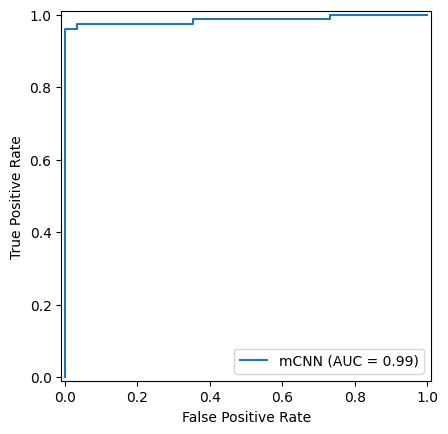

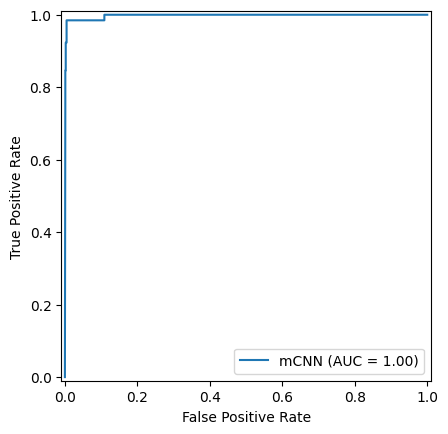

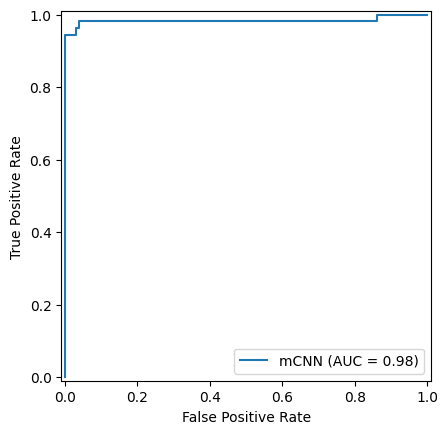

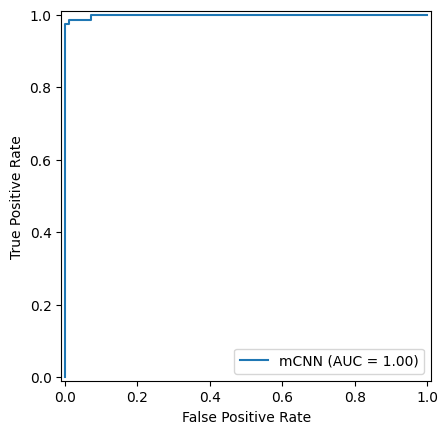

In [9]:
if VALIDATION_MODE == "cross":
    kfold = KFold(n_splits=K_Fold, shuffle=True, random_state=2)
    results = []
    i = 1
    for train_index, test_index in kfold.split(x_train):
        print(i, "/", K_Fold, '\n')
        # Get training and test data
        X_train, X_test = x_train[train_index], x_train[test_index]
        Y_train, Y_test = y_train[train_index], y_train[test_index]
        
        print(X_train.shape)
        print(X_test.shape)
        print(Y_train.shape)
        print(Y_test.shape)
        
        generator = DataGenerator(X_train, Y_train, batch_size=BATCH_SIZE)
        
        # Define Model
        model = DeepScan(
            num_filters=NUM_FILTER,
            num_hidden=NUM_HIDDEN,
            window_sizes=WINDOW_SIZES
        )
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        model.build(input_shape=X_train.shape)
        model.summary()
        
        # Model Evaluation
        history = model.fit(
            generator,
            epochs=EPOCHS,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)],
            verbose=1,
            shuffle=True
        )
        
        # Save model weights after each fold
        weights_filename = f'model_weights_fold_{i}.h5'
        model.save_weights(weights_filename)
        print(f"Saved weights for fold {i} to {weights_filename}")
        
        # Pass the fold_number (i) when calling model_test
        TP, FP, TN, FN, Sens, Spec, Acc, MCC, AUC, F1 = model_test(model, X_test, Y_test, fold_number=i)
        results.append([TP, FP, TN, FN, Sens, Spec, Acc, MCC, AUC, F1])
        
        i += 1
        
        del X_train
        del X_test
        del Y_train
        del Y_test
        gc.collect()
    
    mean_results = np.mean(results, axis=0)
    print(f'TP={mean_results[0]:.4}, FP={mean_results[1]:.4}, TN={mean_results[2]:.4}, FN={mean_results[3]:.4}, Sens={mean_results[4]:.4}, Spec={mean_results[5]:.4}, Acc={mean_results[6]:.4}, MCC={mean_results[7]:.4}, AUC={mean_results[8]:.4}, F1={mean_results[9]:.4} \n')
    
    write_data.append(mean_results[0])
    write_data.append(mean_results[1])
    write_data.append(mean_results[2])
    write_data.append(mean_results[3])
    write_data.append(mean_results[4])
    write_data.append(mean_results[5])
    write_data.append(mean_results[6])
    write_data.append(mean_results[7])
    write_data.append(mean_results[8])
    write_data.append(mean_results[9])

## Independent Test Analysis

Model: "deep_scan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 1097, 512)      2097664   
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1093, 512)      4194816   
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1085, 512)      8389120   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 512)        0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 512)        0         
 2D)                                                             
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 512)        0 

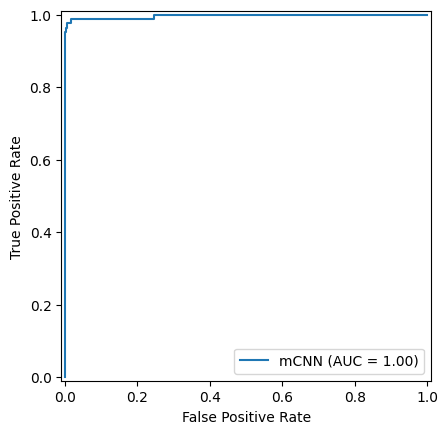

In [9]:
if VALIDATION_MODE == "independent":
    generator = DataGenerator(x_train, y_train, batch_size=BATCH_SIZE)
    
    model = DeepScan(
        num_filters=NUM_FILTER,
        num_hidden=NUM_HIDDEN,
        window_sizes=WINDOW_SIZES
    )
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.build(input_shape=x_train.shape)
    model.summary()
    
    # Train the model
    model.fit(
        generator,
        epochs=EPOCHS,
        shuffle=True,
    )
    
    # Save model weights
    model.save_weights('independent_weights.h5')
        
    TP, FP, TN, FN, Sens, Spec, Acc, MCC, AUC, F1 = model_test(model, x_test, y_test)
    
    # Append metrics to write_data
    write_data.append(TP)
    write_data.append(FP)
    write_data.append(TN)
    write_data.append(FN)
    write_data.append(Sens)
    write_data.append(Spec)
    write_data.append(Acc)
    write_data.append(MCC)
    write_data.append(AUC)
    write_data.append(F1)